In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import time

from mplsoccer import Pitch, VerticalPitch

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler


In [2]:
tqdm.pandas()

In [3]:
frames_general = pd.read_csv('frames_general.csv')
frames_coords = pd.read_csv('frames_coords.csv')
spadl = pd.read_csv('spadl.csv')

In [4]:
frames_coords

,match_id,event_id,frame,team,team_status,x,x_opta,y_opta,y,vx,vy,accel_norm,speed_norm,player_id,player_position,player_with_event
0,2128286,2253487625,1391,1,defense,20.5699,69.59,71.80,14.8252,0.1406,-0.2693,0.0000,0.3038,197365,RCB,False
1,2128286,2253487625,1391,1,defense,19.6386,68.70,40.85,-6.2192,-0.3755,-0.0670,0.2753,0.3815,106760,LWB,False
2,2128286,2253487625,1391,1,defense,20.9583,69.96,60.10,6.8664,0.2215,-0.1173,-0.7083,0.2506,95658,LCB,False
3,2128286,2253487625,1391,90,offense,1.3090,51.25,75.83,17.5660,3.4401,-1.7631,-3.8199,3.8656,60689,RF,False
4,2128286,2253487625,1391,90,offense,-22.8974,28.19,77.05,18.3917,0.1564,0.7657,-1.1231,0.7815,51927,LCB,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966247,2128665,2302283951,62049,39,defense,-44.5684,7.55,51.09,0.7379,-1.1561,-1.3716,1.6599,1.7939,73314,CF,False
9966248,2128665,2302283951,62049,39,defense,-44.7049,7.42,35.24,-10.0335,-0.8269,0.7946,0.5552,1.1469,449988,CF,False
9966249,2128665,2302283951,62049,1,offense,-41.6827,10.30,50.52,0.3533,-0.1988,-1.6911,2.2363,1.7028,152590,LWB,False
9966250,2128665,2302283951,62049,1,offense,-46.7396,5.49,28.29,-14.7631,1.3386,-1.4173,1.4875,1.9495,232937,RWB,False


In [5]:
spadl['type_name'].value_counts()

type_name
pass                348795
bad_touch            25040
aerial_duel          24856
tackle               19019
throw_in             14879
clearance            14554
interception         13524
take_on              13444
cross                 9524
shot                  8710
freekick_short        7906
goalkick              5256
keeper_pick_up        4917
keeper_save           4781
corner_crossed        3164
freekick_crossed      1072
corner_short           686
keeper_claim           513
shot_freekick          359
keeper_punch           308
shot_penalty           125
Name: count, dtype: int64

In [129]:
passes_spadl = spadl[spadl['type_name'] == 'pass']

In [7]:
passes_spadl.sample(10)

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
88810,2128551,2273251583,1,1400,43,Manchester City,103025,Riyad Mahrez,1,pass,75.60,5.032,97.545,7.956,1,success,1,foot
235521,2128508,2262135865,2,4133,21,West Ham United,40669,Angelo Ogbonna,1,pass,60.06,20.740,56.280,60.928,0,fail,2,head
125712,2128493,2259618131,2,2884,20,Southampton,88900,Jack Stephens,1,pass,57.96,37.672,55.965,38.148,0,fail,1,foot
385157,2128492,2259302839,1,324,43,Manchester City,206325,Oleksandr Zinchenko,1,pass,15.96,50.864,11.025,35.700,1,success,2,head
43208,2128615,2291191965,2,3274,90,Burnley,103914,Charlie Taylor,1,pass,63.42,3.740,45.675,62.220,0,fail,1,foot
298374,2128563,2274901427,1,1083,4,Newcastle United,153127,Isaac Hayden,1,pass,63.00,51.952,46.725,49.980,1,success,1,foot
330537,2128495,2260056155,1,1295,14,Liverpool,68312,Xherdan Shaqiri,1,pass,83.37,9.996,87.570,2.380,1,success,1,foot
389105,2128571,2271124229,2,4142,43,Manchester City,205651,Gabriel Jesus,1,pass,81.69,23.732,76.545,23.460,1,success,1,foot
104970,2128324,2219086267,2,5644,20,Southampton,93100,Jannik Vestergaard,1,pass,38.64,40.800,58.905,60.724,1,success,1,foot
240034,2128550,2273206663,2,4978,14,Liverpool,175592,Naby Keita,1,pass,43.89,45.492,45.360,49.572,1,success,1,foot


In [8]:
frames_coords[frames_coords['event_id'] == 2282711179]

,match_id,event_id,frame,team,team_status,x,x_opta,y_opta,y,vx,vy,accel_norm,speed_norm,player_id,player_position,player_with_event
7832886,2128582,2282711179,5771,1,offense,31.9400,80.42,87.58,25.5568,0.0000,0.0000,0.0000,0.0000,176297,LW,False
7832887,2128582,2282711179,5771,36,defense,34.5588,82.91,81.27,21.2617,-0.2235,-1.8933,0.0000,1.9065,115382,RF,False
7832888,2128582,2282711179,5771,1,offense,28.8049,77.43,66.04,10.9059,-0.1951,-3.4430,0.0000,3.4486,141746,AM,True
7832889,2128582,2282711179,5771,36,defense,30.9707,79.50,63.71,9.3252,-2.5291,-2.6764,0.0000,3.6823,227127,LM,False
7832890,2128582,2282711179,5771,1,offense,36.6417,84.90,81.42,21.3633,-2.0811,0.0509,0.0000,2.0817,106760,LWB,False
7832891,2128582,2282711179,5771,36,defense,41.9813,89.98,43.66,-4.3131,4.1390,0.8845,0.0000,4.2325,111478,LCB,False
7832892,2128582,2282711179,5771,36,defense,35.1894,83.51,69.95,13.5649,-0.1533,-2.2858,0.0000,2.2909,116216,AM,False
7832893,2128582,2282711179,5771,1,offense,40.6584,88.72,32.28,-12.0487,0.0000,0.0000,0.0000,0.0000,95658,LCB,False
7832894,2128582,2282711179,5771,36,defense,38.4010,86.57,53.84,2.6107,1.6956,2.1277,-1.3106,2.7207,243505,LWB,False
7832895,2128582,2282711179,5771,36,defense,50.8761,98.45,51.34,0.9106,0.0000,0.0000,0.0000,0.0000,215059,GK,False


In [9]:
frames_coords['x'] = frames_coords['x']+52.5
frames_coords['y'] = frames_coords['y']+34

In [10]:
event_id_teste = 2294138645
event_test = spadl[spadl['event_id'] == event_id_teste]
frame_event_teste = frames_coords[frames_coords['event_id'] == event_id_teste]

In [11]:
event_test['start_x'].values[0]

69.09

In [12]:
frame_event_teste

,match_id,event_id,frame,team,team_status,x,x_opta,y_opta,y,vx,vy,accel_norm,speed_norm,player_id,player_position,player_with_event
8879747,2128622,2294138645,46529,3,offense,56.1110,53.44,62.58,42.5528,0.7831,1.0003,-0.3454,1.2703,84450,LWB,False
8879748,2128622,2294138645,46529,3,offense,59.0016,56.19,32.85,22.3348,0.6466,-3.0424,1.4099,3.1103,153256,RM,False
8879749,2128622,2294138645,46529,3,offense,67.5743,64.36,66.74,45.3851,0.8139,-1.2333,0.6050,1.4777,182539,LM,False
8879750,2128622,2294138645,46529,3,offense,65.7667,62.63,4.91,3.3355,0.3393,-2.5352,0.7785,2.5578,98745,RWB,False
8879751,2128622,2294138645,46529,3,offense,82.7824,78.84,28.47,19.3592,-0.5174,0.4544,0.8052,0.6886,54694,CF,False
8879752,2128622,2294138645,46529,4,defense,82.2658,78.35,43.40,29.5108,-0.3821,-2.9966,0.8971,3.0208,114243,RWB,False
8879753,2128622,2294138645,46529,4,defense,69.1598,65.87,12.78,8.6872,0.0738,-2.9233,1.3732,2.9243,56983,LWB,False
8879754,2128622,2294138645,46529,4,defense,82.3692,78.45,25.25,17.1707,0.2608,0.4385,0.9580,0.5102,58845,CB,False
8879755,2128622,2294138645,46529,3,offense,67.5794,64.36,28.06,19.0781,-2.1366,-3.1046,-0.4957,3.7688,184029,AM,True
8879756,2128622,2294138645,46529,4,defense,78.5212,74.78,14.78,10.0479,-0.9058,-0.2669,0.2807,0.9443,106618,LCB,False


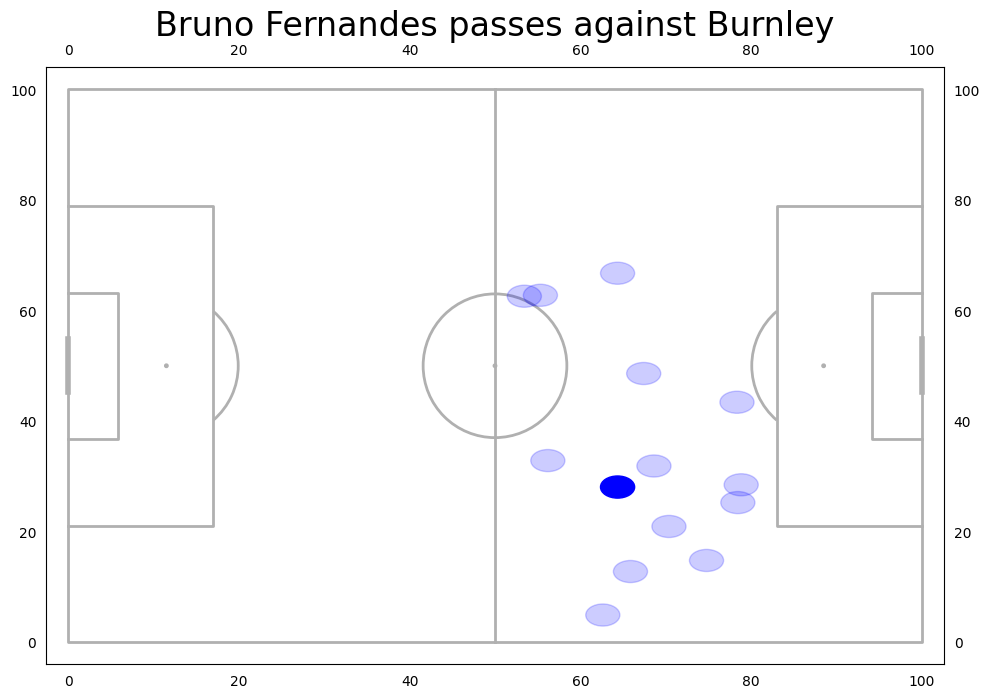

In [13]:
pitch = Pitch(pitch_type='opta',  # example plotting a tracab pitch
              axis=True, label=True) 
fig, ax = pitch.draw(figsize=(10, 7))

'''x = event_test['start_x'].values[0]
y = event_test['start_y'].values[0]
id_person = event_test['player_id'].values[0]
name_person = event_test['player_name'].values[0]

circle = plt.Circle((x,y),2,color="blue")
circle.set_alpha(1)
ax.add_patch(circle)'''

for i,person in frame_event_teste.iterrows():
    #if pass made by Lucy Bronze
    if person['player_with_event'] == True:
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="blue")
        circle.set_alpha(1)
        ax.add_patch(circle)
    else:
        x=person['x_opta']
        y=person['y_opta']
        #plot circle
        circle = plt.Circle((x,y),2,color="blue")
        circle.set_alpha(.2)
        ax.add_patch(circle)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

In [14]:
passes_match_id = spadl[spadl['type_name'] == 'pass']
passes_match_id = passes_match_id[passes_match_id['match_id'] == 2128286]

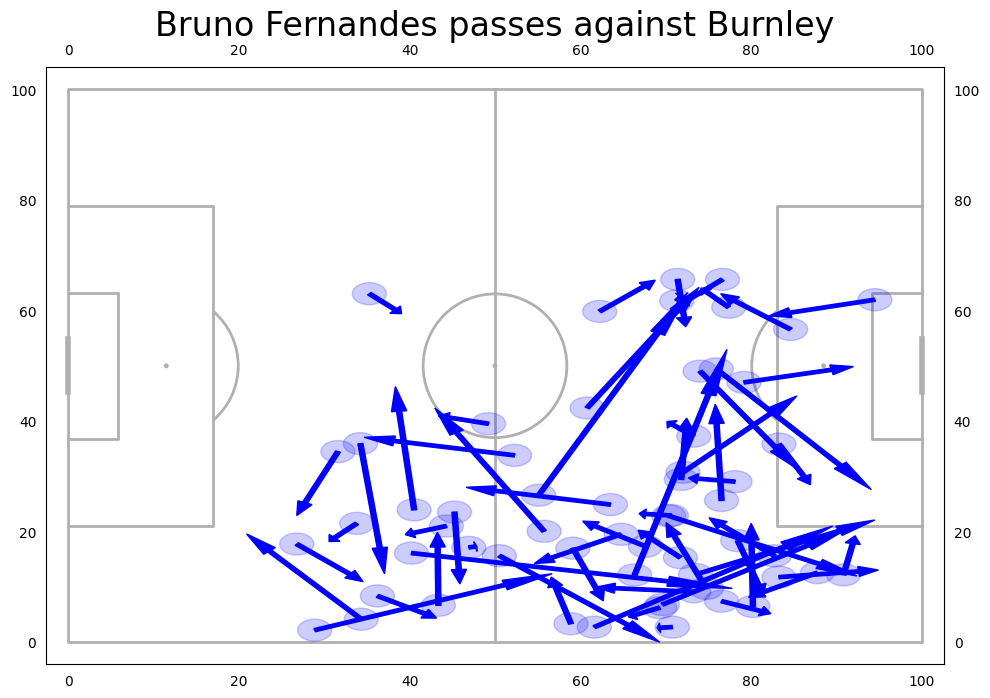

In [15]:
pitch = Pitch(pitch_type='opta',  # example plotting a tracab pitch
              pitch_length=105, pitch_width=68,
              axis=True, label=True) 
fig, ax = pitch.draw(figsize=(10, 7))

for i,thepass in passes_match_id.iterrows():
    #if pass made by Lucy Bronze
    if thepass['player_name']=='Bruno Fernandes':
        x=thepass['start_x']
        y=thepass['start_y']
        #plot circle
        passCircle=plt.Circle((x,y),2,color="blue")
        passCircle.set_alpha(.2)
        ax.add_patch(passCircle)
        dx=thepass['end_x']-x
        dy=thepass['end_y']-y
        #plot arrow
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)

ax.set_title("Bruno Fernandes passes against Burnley", fontsize = 24)
fig.set_size_inches(10, 7)
plt.show()

In [16]:
spadl.type_name

0                   pass
1                   pass
2                   pass
3                   shot
4               goalkick
               ...      
521427       aerial_duel
521428       aerial_duel
521429    freekick_short
521430              pass
521431              pass
Name: type_name, Length: 521432, dtype: object

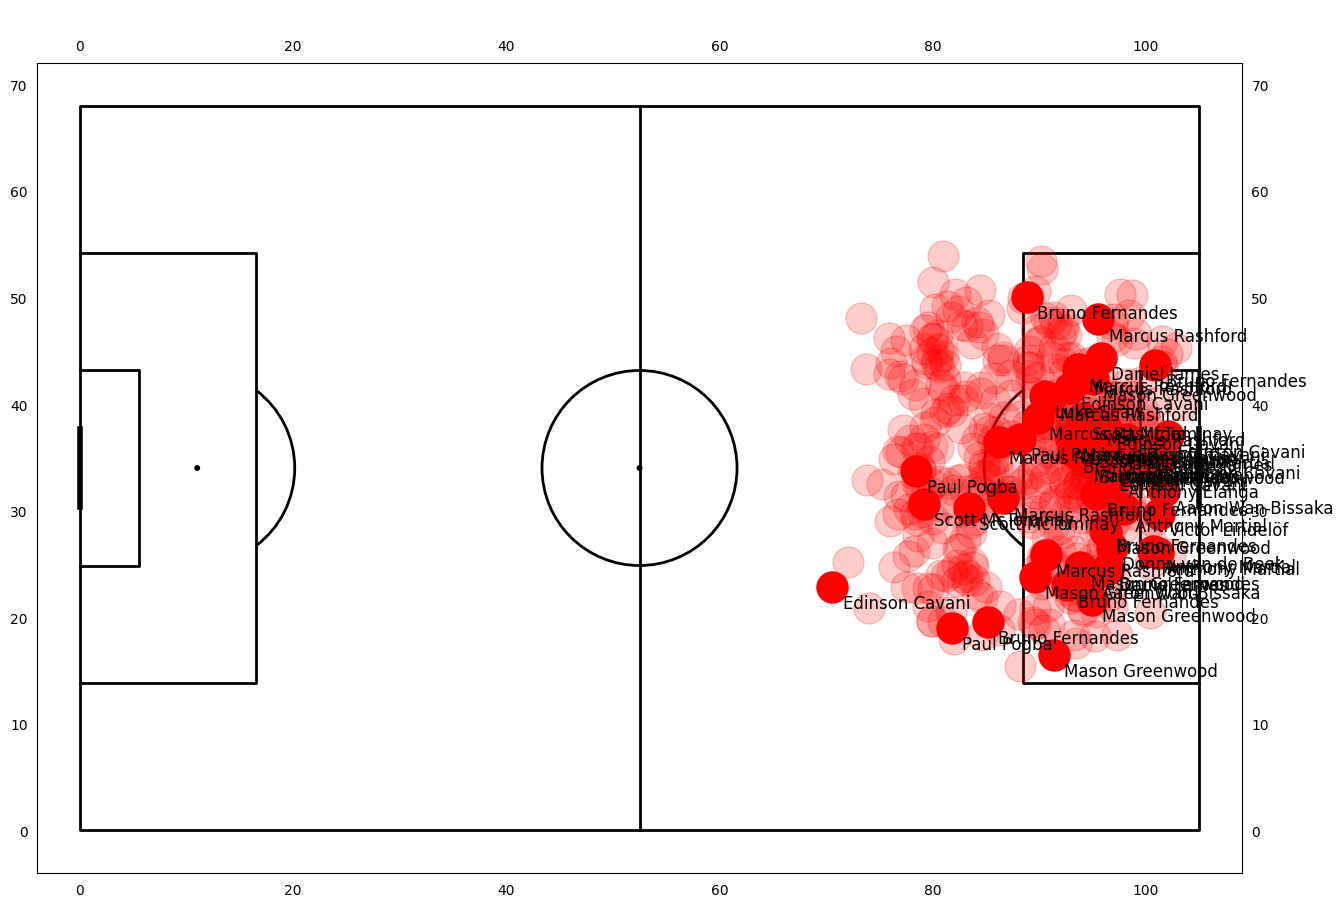

In [17]:
#create pitch
pitch = Pitch(line_color='black', pitch_type='uefa', pitch_length=105, pitch_width=68, axis=True, label=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#query
mask_england = (spadl.type_name == 'shot') & (spadl.team_name == 'Manchester United')
#finding rows in the df and keeping only necessary columns
df_england = spadl.loc[mask_england, ['start_x', 'start_y', 'result_name', "player_name"]]

#plot them - if shot ended with Goal - alpha 1 and add name
#for England
for i, row in df_england.iterrows():
    if row["result_name"] == 'success':
    #make circle
       pitch.scatter(row.start_x, row.start_y, alpha = 1, s = 500, color = "red", ax=ax['pitch'])
       pitch.annotate(row["player_name"], (row.start_x + 1, row.start_y - 2), ax=ax['pitch'], fontsize = 12)
    else:
       pitch.scatter(row.start_x, row.start_y, alpha = 0.2, s = 500, color = "red", ax=ax['pitch'])

In [18]:
#passes_spadl_success = passes_spadl[passes_spadl['result_id'] == 1]
#passes_spadl_failure = passes_spadl[passes_spadl['result_id'] == 0]

In [19]:
#print(len(passes_spadl_success), len(passes_spadl_failure))

286186 62609


In [25]:
#passes_spadl_success_balanced = passes_spadl_success.sample(len(passes_spadl_failure), random_state=42, axis=0)

In [22]:
#passes_spadl_model = pd.concat([passes_spadl_success_balanced, passes_spadl_failure])

In [130]:
passes_spadl_model = passes_spadl

In [131]:
players_dict = dict()
teams_dict = dict()
bodypart_dict = dict()

In [132]:
def check_player(x):
    if x['player_id'] in players_dict.keys():
        pass
    else:
        players_dict[x['player_id']] = x['player_name']

def check_team(x):
    if x['team_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['team_id']] = x['team_name']

def check_bodypart(x):
    if x['bodypart_id'] in teams_dict.keys():
        pass
    else:
        teams_dict[x['bodypart_id']] = x['bodypart_name']

In [133]:
spadl.apply(check_player, axis=1)
spadl.apply(check_team, axis=1)
spadl.apply(check_bodypart, axis=1);

In [134]:
spadl

,match_id,event_id,period_id,time_seconds,team_id,team_name,player_id,player_name,type_id,type_name,start_x,start_y,end_x,end_y,result_id,result_name,bodypart_id,bodypart_name
0,2128286,2253487625,1,0,90,Burnley,60551,Ashley Westwood,1,pass,52.815,34.204,32.025,34.204,1,success,1,foot
1,2128286,2253487639,1,2,90,Burnley,17761,James Tarkowski,1,pass,31.080,36.312,38.220,15.844,1,success,1,foot
2,2128286,2253487685,1,7,90,Burnley,68983,Matthew Lowton,1,pass,43.365,12.512,90.300,49.708,1,success,1,foot
3,2128286,2253487689,1,11,90,Burnley,90517,Robbie Brady,12,shot,90.300,49.708,90.300,49.708,0,fail,1,foot
4,2128286,2253488053,1,44,1,Manchester United,51940,David de Gea,22,goalkick,5.040,33.728,44.310,21.012,1,success,1,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521427,2128605,2287659813,2,5636,39,Wolverhampton Wanderers,159533,Adama Traoré,23,aerial_duel,78.960,20.672,78.960,20.672,1,success,1,foot
521428,2128605,2287659811,2,5636,49,Sheffield United,109638,Kean Bryan,23,aerial_duel,78.960,20.672,78.960,20.672,0,fail,1,foot
521429,2128605,2287660049,2,5668,49,Sheffield United,225321,Aaron Ramsdale,5,freekick_short,23.520,38.828,34.125,36.448,1,success,1,foot
521430,2128605,2287660075,2,5672,49,Sheffield United,108416,John Egan,1,pass,37.485,35.428,78.960,66.028,1,success,1,foot


In [135]:
def distancia2d(x1, y1, x2, y2):
    a = x2 - x1
    b = y2 - y1
    c = math.sqrt(math.pow(a, 2) + math.pow(b, 2))
    return c

In [136]:
def angle_cos(xi,xf,d):
    cat_adj = xf-xi
    hip = d
    if hip == 0:
        hip=1
    cos = cat_adj/hip
    ang_in_radians = math.acos(cos)
    return ang_in_radians

In [137]:
passes_spadl_model['distance'] = [distancia2d(passe['start_x'], passe['start_y'], passe['end_x'], passe['end_y']) for i, passe in passes_spadl_model.iterrows()]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\3873093024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_spadl_model['distance'] = [distancia2d(passe['start_x'], passe['start_y'], passe['end_x'], passe['end_y']) for i, passe in passes_spadl_model.iterrows()]


In [138]:
passes_spadl_model['angle'] = [angle_cos(passe['start_x'], passe['end_x'], passe['distance']) for i, passe in passes_spadl_model.iterrows()]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\2712366495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_spadl_model['angle'] = [angle_cos(passe['start_x'], passe['end_x'], passe['distance']) for i, passe in passes_spadl_model.iterrows()]


In [139]:
evento_anterior = []
evento_2_anterior = []
evento_3_anterior = []
#evento_4_anterior = []
#evento_5_anterior = []
for i, row in passes_spadl_model.iterrows():
    #if spadl.iloc[i-1]['type_name'] == 'pass' and spadl.iloc[i-1]['result_name'] == 'success':
    evento_anterior.append(spadl.iloc[i-1]['type_name'])
    evento_2_anterior.append(spadl.iloc[i-2]['type_name'])
    evento_3_anterior.append(spadl.iloc[i-3]['type_name'])
    #evento_4_anterior.append(spadl.iloc[i-4]['type_name'])
    #evento_5_anterior.append(spadl.iloc[i-5]['type_name'])

In [140]:
passes_spadl_model['previous_event_type'] = evento_anterior
passes_spadl_model['2_previous_event_type'] = evento_2_anterior
passes_spadl_model['3_previous_event_type'] = evento_3_anterior
#passes_spadl_model['4_previous_event_type'] = evento_4_anterior
#passes_spadl_model['5_previous_event_type'] = evento_5_anterior

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1665433118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_spadl_model['previous_event_type'] = evento_anterior
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1665433118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_spadl_model['2_previous_event_type'] = evento_2_anterior
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1665433118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [36]:
numpy_frames_coords_event_id = frames_coords['event_id'].values

In [37]:
def check_distance_tracking(row, x_player, y_player):
    return distancia2d(x_player, y_player, row['x'], row['y'])

def check_close_players(row):
    #inicio = time.time()
    pass_tracking = frames_coords[numpy_frames_coords_event_id == row['event_id']]
    #inicio_meio = time.time()
    player_with_event_tracking = pass_tracking[pass_tracking['player_with_event'].values == True]
    #meio = time.time()
    if len(player_with_event_tracking['x']) == 1:
        x_player = player_with_event_tracking['x'].values[0]
        y_player = player_with_event_tracking['y'].values[0]
        
        distance = pass_tracking.apply(check_distance_tracking, args=(x_player, y_player), axis=1).values
        #meio_fim = time.time()
        num_perto = (distance <= 5).sum() - 1   #Número de indivíduos perto do passador menos ele mesmo
        #fim = time.time()
        #print(fim-meio_fim,meio_fim-meio,meio-inicio_meio, inicio_meio-inicio)
        return num_perto
    else:
        return 0

In [38]:
distance_all = passes_spadl_model.progress_apply(check_close_players, axis=1)

100%|██████████| 125218/125218 [23:23<00:00, 89.19it/s] 


In [39]:
passes_spadl_model['close_players'] = list(distance_all.values)

In [141]:
y = passes_spadl_model['result_id'].values
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type', '4_previous_event_type', '5_previous_event_type', 'close_players']]
passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type', '2_previous_event_type', '3_previous_event_type']]
#passes_spadl_model = passes_spadl_model[['bodypart_id', 'distance', 'angle', 'previous_event_type']]

In [142]:
mms = MinMaxScaler()

#passes_spadl_model[['distance','angle', 'close_players']] = mms.fit_transform(passes_spadl_model[['distance', 'angle', 'close_players']])
passes_spadl_model[['distance','angle']] = mms.fit_transform(passes_spadl_model[['distance', 'angle']])

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\316759810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_spadl_model[['distance','angle']] = mms.fit_transform(passes_spadl_model[['distance', 'angle']])


In [143]:
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5, 6, 7])], remainder='passthrough')
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3, 4, 5])], remainder='passthrough')
#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(sparse=False), [0, 3])], remainder='passthrough')
passes_spadl_model = np.array(columnTransformer.fit_transform(passes_spadl_model))

e:\Desktop\Henrique\8_PERIODO\CDAF\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [144]:
X_train, X_test, y_train, y_test = train_test_split(passes_spadl_model, y, test_size=0.1, random_state=42)

In [145]:
lr_model = LogisticRegression()

In [146]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [147]:
lr_model.score(X_train, y_train)

0.8468215918321839

In [148]:
lr_model.score(X_test, y_test)

0.8471616972477064

In [149]:
roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

0.791935218314673

In [150]:
positive_class = len(passes_spadl[passes_spadl['result_id'] == 1])
negative_class = len(passes_spadl[passes_spadl['result_id'] == 0])

In [ ]:
#scale_pos_weight=negative_class/positive_class

In [151]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [152]:
# make predictions for test data
y_pred_test = model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

In [153]:
# evaluate predictions
accuracy = accuracy_score(y_train, predictions_train)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

# evaluate predictions
accuracy = accuracy_score(y_test, predictions_test)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 87.790%
Accuracy: 87.162%


In [154]:
precision = precision_score(y_test, predictions_test)
print("precision: %.3f%%" % (precision * 100.0))

precision: 90.166%


In [155]:
recall = recall_score(y_test, predictions_test)
print("recall: %.3f%%" % (recall * 100.0))

recall: 94.713%


In [156]:
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("auc: %.3f%%" % (auc * 100.0))

auc: 87.279%


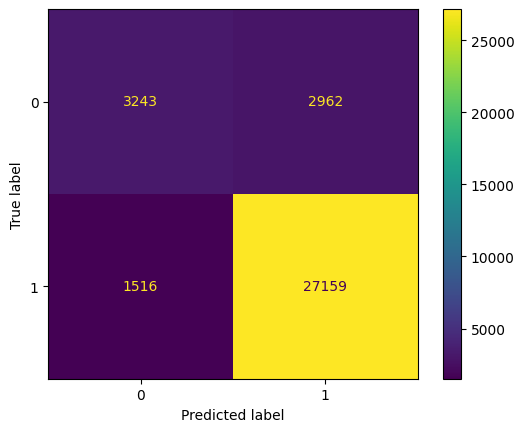

In [157]:
cm = confusion_matrix(y_test, predictions_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()